<a href="https://colab.research.google.com/github/ayuksekdag/winacademy_python_dna/blob/main/final_assignment/final_co2Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment / Questions

- What is the biggest predictor of a large CO2 output per capita of a country?
- Which countries are making the biggest strides in decreasing CO2 output?
- Which non-fossil fuel energy technology will have the best price in the future?

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt

# Ingest sources

- source 1: https://ourworldindata.org/co2-emissions#per-capita-co2-emissions
  - filename: co2-per-capita-marimekko.csv
  - alias: co2_cap

- source 2: https://ourworldindata.org/grapher/gdp-per-capita-worldbank
  - filename:per-capita-energy-use.csv
  - alias: engy_cap

- source 3: https://ourworldindata.org/grapher/per-capita-energy-use
  - filename: gdp-per-capita-worldbank
  - alias: gdp_cap

In [2]:
co2_cap = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/co2-per-capita-marimekko.csv')
gdp_cap = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/gdp-per-capita-worldbank.csv')
engy_cap = pd.read_csv('https://raw.githubusercontent.com/ayuksekdag/winacademy_python_dna/main/final_assignment/per-capita-energy-use.csv')

In [ ]:
# co2_cap.head(3)
# gdp_cap.head(3)
# engy_cap.head(3)

# Data Prep 1
Renaming columns

Data conversions
  - year column to date

Cleaning of data.
  - Goal: All datasets must have same countries and same selection of years
  - How: To achieve this I take a inner join (intersection) of all datasets on country and year of the measure.


In [3]:
#rename long column names with spaces and special characters
co2_cap.rename(columns={'Annual CO₂ emissions (per capita)': 'c02'}, inplace=True)
engy_cap.rename(columns={'Primary energy consumption per capita (kWh/person)': 'energy_consumption'}, inplace=True)
gdp_cap.rename(columns={'GDP per capita, PPP (constant 2017 international $)': 'gdp'}, inplace=True)
# print(gdp_cap.dtypes)
# print(engy_cap.dtypes)

In [4]:
#change datatype year to datetime
co2_cap['Year'] = pd.to_datetime(co2_cap['Year'], format='%Y')
gdp_cap['Year'] = pd.to_datetime(gdp_cap['Year'], format='%Y')
engy_cap['Year'] = pd.to_datetime(engy_cap['Year'], format='%Y')

# print(co2_cap.dtypes)
# print(gdp_cap.dtypes)
# print(engy_cap.dtypes)

# print(f' \n grootte co2_cap  {co2_cap.shape}')
# print(f' \n grootte engy_cap  {engy_cap.shape}')
# print(f' \n grootte gdp_cap {gdp_cap.shape}')


In [64]:
# INTERSECTION INNER JOIN TO CREATE
# 1 DATASET BASED ON COUNTRY AND YEAR.


merged_co2_gdp = (
    pd.merge(co2_cap,gdp_cap, how="inner", on=['Year','Code'], suffixes=('', '_y'))
    .drop(['Entity_y','Continent'], axis=1)
)

# print(merge_co2_gdp.dtypes, '\n')

merged_co2_gdp_engy = (
    pd.merge(merged_co2_gdp ,engy_cap, how="inner", on=['Year','Code'], suffixes=('', '_y'))
    .drop(['Entity_y','Code'], axis=1)
)

print(f'final dataset struct merged_co2_gdp_engy \n\n{merged_co2_gdp_engy.dtypes}')


final dataset struct merged_co2_gdp_engy 

Entity                        object
Year                  datetime64[ns]
c02                          float64
gdp                          float64
energy_consumption           float64
dtype: object


# Question / Answer 1:
What is the biggest predictor of a large CO2 output per capita of a country?


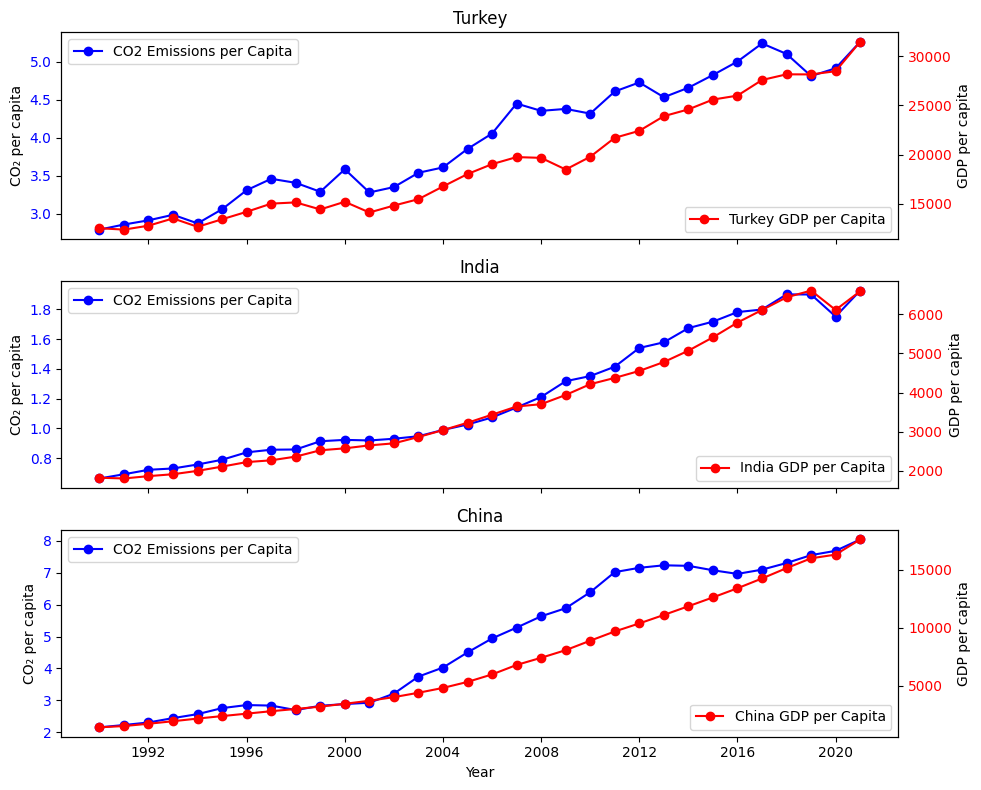

In [94]:
countries_to_plot = {"India", "Turkey", "China"}

# Create subplots
fig, ax = plt.subplots(len(countries_to_plot), 1, figsize=(10, 8), sharex=True)


for i, country in enumerate(countries_to_plot):

  df = merged_co2_gdp_engy[merged_co2_gdp_engy["Entity"] == country]

  # Plot the first dataset c02  on the left y-axis
  ax[i].set_title(f"{country}")
  ax[i].plot(df["Year"], df["c02"], label="CO2 Emissions per Capita", marker='o', color="blue")

  ax[i].set_ylabel('CO₂ per capita', color="black")
  ax[i].tick_params(axis='y', labelcolor="blue")
  ax[i].legend()

  # Create a second gdp y-axis on the right with a shared x-axis
  ax2 = ax[i].twinx()

  # Plot the second dataset on the right y-axis
  ax2.plot(df["Year"], df["gdp"], label=f"{country} GDP per Capita", marker='o', color="red")
  ax2.set_ylabel('GDP per capita', color="black")
  ax2.tick_params(axis='y', labelcolor="red")
  ax2.legend(loc='lower right')

# # Set common x-axis label
ax[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()



In [ ]:
#which country codes do not exist in gdp_cap


# filter_remove_engy_cap_country_codes = engy_cap[engy_cap.Code.isin(gdp_cap.Code) == False]['Code'].unique()
# filter_remove_engy_cap_country_codes

In [ ]:
# engy_cap[engy_cap.Code.isin(['TUR'])]

In [ ]:
# #which country codes do not exist in gdp_cap
# # remove those countries
# engy_cap.drop(
#     engy_cap[engy_cap[engy_cap.Code.isin(filter_remove_engy_cap_country_codes)]].index, inplace=True
# )
# print(engy_cap)

In [ ]:
# gdp_cap[gdp_cap.Code.isin(engy_cap.Code) == False]['Entity'].unique()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CO2 emissions data
co2_data = pd.read_csv("path/to/your/co2-emissions-per-capita.csv")
co2_data = co2_data.rename(columns={"CO2 emissions (metric tons per capita)": "CO2_per_capita"})

# Load energy consumption data
energy_data = pd.read_csv("path/to/your/energy-use-per-capita.csv")
energy_data = energy_data.rename(columns={"Energy use (per capita)": "Energy_per_capita"})

# Merge data on 'Entity' column
merged_data = pd.merge(co2_data, energy_data, on="Entity")

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(merged_data["Energy_per_capita"], merged_data["CO2_per_capita"], alpha=0.7)
plt.title("CO2 Emissions vs Energy Consumption per Capita")
plt.xlabel("Energy Consumption per Capita (kWh)")
plt.ylabel("CO2 Emissions per Capita (metric tons)")
plt.grid(True)
plt.show()